In [485]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
import math
import matplotlib.pyplot as plt
import os

# imports for Bumpy plots
import json
from urllib.request import urlopen
from highlight_text import fig_text

from mplsoccer import Bumpy, FontManager, add_image

# plotting pitch
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
from mplsoccer import pitch as mpl_pitch

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 100)

# **Calculating Player KPIs from xT & xG data**

In [486]:
repo_kpi = r'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/PLAYER KPIs'

In [487]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

## **Loading Opta Data**

In [488]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT & xG/Bayesian_Opta_xT_xG.csv').drop(columns=['Unnamed: 0'])

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df)} rows loaded.\n')

3126182 rows loaded.

CPU times: user 20.1 s, sys: 5.04 s, total: 25.1 s
Wall time: 28 s


## **Loading Player Position Data**

In [489]:
df_players = pd.read_csv(os.path.join(repo_kpi, 'df_players.csv'))

## **Creating Pass / Dribble / Shot / Cross Flag**

In [490]:
df['mainEventType'] = None
df['mainEventType'] = df.eventSubType.apply(lambda x: 'Cross' if x == 'Cross' else 'Pass' if x in (opta_successful_pass_events + opta_failed_pass_events) else 'Dribble' if x in ['Dribble','Failed Dribble'] else 'Shot' if x in (opta_successful_shot_events + opta_failed_shot_events) else 'Other')

df.mainEventType.value_counts()

Pass       1786072
Other      1227792
Dribble      62602
Shot         43813
Cross         5903
Name: mainEventType, dtype: int64

## **Calculating Aggregate Metrics**

**(PER SEASON)**

* Combined xT/90
* Excess xG/90

In [491]:
df_xT = df.groupby(['competition','season','playerId','matchId'])\
        .agg({'xT':np.sum,'excess_xG':np.sum,'minsPlayed':np.mean,'x1':'count'})\
        .reset_index().rename(columns={'x1':'numActions'})\
        .groupby(['competition','season','playerId'])\
        .agg({'xT':np.sum,'excess_xG':np.sum,'minsPlayed':np.sum,'numActions':np.sum,'matchId':'nunique'})\
        .reset_index()\
        .rename(columns={'matchId':'numMatches'})\
        .sort_values('xT', ascending=False)

# calculating PER 90 metrics
df_xT['xT_per_90'] = (df_xT.xT / df_xT.minsPlayed) * 90
df_xT['excess_xG_per_90'] = (df_xT.excess_xG / df_xT.minsPlayed) * 90
df_xT['xGT_per_90'] = df_xT.xT_per_90 + df_xT.excess_xG_per_90

# min mins filter
df_xT = df_xT.loc[(df_xT['minsPlayed'] > 900)]

# calculating per 90 RANKs
#df_xT['season_xT_rank'] = df_xT.sort_values('xT', ascending=False).groupby(['competition','season']).cumcount() + 1
df_xT['season_xT_per_90_rank'] = df_xT.sort_values('xT_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1
df_xT['season_excess_xG_per_90_rank'] = df_xT.sort_values('excess_xG_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1
df_xT['season_xGT_per_90_rank'] = df_xT.sort_values('xGT_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1


# calculating per 90 rank PERCENTILES
df_xT['season_xT_per_90_percentile_rank'] = 100 - df_xT.season_xT_per_90_rank.apply(lambda x: percentileofscore(df_xT.season_xT_per_90_rank.values, x))
df_xT['season_excess_xG_per_90_percentile_rank'] = 100 - df_xT.season_excess_xG_per_90_rank.apply(lambda x: percentileofscore(df_xT.season_excess_xG_per_90_rank.values, x))
df_xT['season_xGT_per_90_percentile_rank'] = 100 - df_xT.season_xGT_per_90_rank.apply(lambda x: percentileofscore(df_xT.season_xGT_per_90_rank.values, x))


# joining on df_players to get player names
df_xT = df_xT.merge(df_players)

# each row here is per player per season
df_xT.head()

,competition,season,playerId,xT,excess_xG,minsPlayed,numActions,numMatches,xT_per_90,excess_xG_per_90,xGT_per_90,season_xT_per_90_rank,season_excess_xG_per_90_rank,season_xGT_per_90_rank,season_xT_per_90_percentile_rank,season_excess_xG_per_90_percentile_rank,season_xGT_per_90_percentile_rank,playerName,position
0,English Premier League,2019/20,169187,13.869497,4.00000,3321,4662,38,0.375867,0.108401,0.484268,2,104,22,99.319971,65.748031,90.730136,Trent Alexander-Arnold,Defender
1,English Premier League,2020/21,169187,11.005784,2.00000,3178,4261,36,0.311680,0.056639,0.368320,1,167,39,99.749463,47.709377,84.359341,Trent Alexander-Arnold,Defender
2,English Premier League,2018/19,169187,9.917739,1.00000,2552,3333,29,0.349764,0.035266,0.385030,1,205,53,99.749463,36.828919,80.350752,Trent Alexander-Arnold,Defender
3,Champions League,2018/19,169187,3.944734,0.00000,952,1178,11,0.372927,0.000000,0.372927,1,31,7,99.749463,87.115247,97.172513,Trent Alexander-Arnold,Defender
4,English Premier League,2017/18,169187,2.442100,0.23358,1637,2050,19,0.134263,0.012842,0.147105,57,136,79,79.205440,56.585540,72.906228,Trent Alexander-Arnold,Defender


---

## **Outputting xT Tables for Thesis**

In [492]:
df_xT.head()

,competition,season,playerId,xT,excess_xG,minsPlayed,numActions,numMatches,xT_per_90,excess_xG_per_90,xGT_per_90,season_xT_per_90_rank,season_excess_xG_per_90_rank,season_xGT_per_90_rank,season_xT_per_90_percentile_rank,season_excess_xG_per_90_percentile_rank,season_xGT_per_90_percentile_rank,playerName,position
0,English Premier League,2019/20,169187,13.869497,4.00000,3321,4662,38,0.375867,0.108401,0.484268,2,104,22,99.319971,65.748031,90.730136,Trent Alexander-Arnold,Defender
1,English Premier League,2020/21,169187,11.005784,2.00000,3178,4261,36,0.311680,0.056639,0.368320,1,167,39,99.749463,47.709377,84.359341,Trent Alexander-Arnold,Defender
2,English Premier League,2018/19,169187,9.917739,1.00000,2552,3333,29,0.349764,0.035266,0.385030,1,205,53,99.749463,36.828919,80.350752,Trent Alexander-Arnold,Defender
3,Champions League,2018/19,169187,3.944734,0.00000,952,1178,11,0.372927,0.000000,0.372927,1,31,7,99.749463,87.115247,97.172513,Trent Alexander-Arnold,Defender
4,English Premier League,2017/18,169187,2.442100,0.23358,1637,2050,19,0.134263,0.012842,0.147105,57,136,79,79.205440,56.585540,72.906228,Trent Alexander-Arnold,Defender


In [493]:
df_xT_summary = df_xT.loc[(df_xT['competition'] == 'English Premier League') & (df_xT['season_xT_per_90_rank'] <= 5), ['season','season_xT_per_90_rank','playerName','xT_per_90','season_excess_xG_per_90_percentile_rank']]\
                .sort_values(['season','season_xT_per_90_rank'])

df_xT_summary['xT_per_90'] = np.round(df_xT_summary.xT_per_90, 3)
df_xT_summary['season_excess_xG_per_90_percentile_rank'] = np.floor(df_xT_summary.season_excess_xG_per_90_percentile_rank).astype(int)

df_xT_summary.to_latex(index=False).replace('\\\\\n','\\')

'\\begin{tabular}{lrlrr}\n\\toprule\n  season &  season\\_xT\\_per\\_90\\_rank &              playerName &  xT\\_per\\_90 &  season\\_excess\\_xG\\_per\\_90\\_percentile\\_rank \\\\midrule\n 2017/18 &                      1 &       Philippe Coutinho &      0.399 &                                       84 \\ 2017/18 &                      2 &             Chris Brunt &      0.378 &                                       15 \\ 2017/18 &                      3 &           Cesc Fàbregas &      0.335 &                                       28 \\ 2017/18 &                      4 &            Robbie Brady &      0.311 &                                        2 \\ 2017/18 &                      5 &         Kevin De Bruyne &      0.304 &                                       65 \\ 2018/19 &                      1 &  Trent Alexander-Arnold &      0.350 &                                       36 \\ 2018/19 &                      2 &            James Milner &      0.346 &                            

---

## Plotting Player xT Pitch Profiles

In [494]:
teams = df[['homeTeamName','homeTeamId']].drop_duplicates().reset_index(drop=True)
teams.head(20)

,homeTeamName,homeTeamId
0,Arsenal,3
1,Brighton and Hove Albion,36
2,Chelsea,8
3,Crystal Palace,31
4,Everton,11
5,Manchester United,1
6,Newcastle United,4
7,Southampton,20
8,Watford,57
9,West Bromwich Albion,35


In [495]:
def plot_xTMap(xT, team_id, actions, seasons, bins=(18,12), cmap='Reds', players=None, vmax_override=None, saveFlag=0):
    """
    player_id 61366 = KDB
    player_id 17878 = Fabregas
    player_id 169187 = TAA
    player_id 172780 = James Madison
    player_id 122798 = Andrew Robertson
    """
    
    if players == None:
        xT = xT.loc[(xT['playerTeamId'] == team_id) & (xT['eventSubType'].isin(actions)) & (xT['seasonIndex'].isin(seasons))]
    else:
        xT = xT.loc[(xT['playerTeamId'] == team_id) & (xT['eventSubType'].isin(actions)) &  (xT['playerId'].isin(players)) & (xT['seasonIndex'].isin(seasons))]
        
    # getting rid of corners
    xT = xT.loc[~((xT['x1_m'] >= 104.4) & (xT['y1_m'] >= 66.5))].reset_index(drop=True)
    xT = xT.loc[~((xT['x1_m'] >= 104.4) & (xT['y1_m'] <= 1.5))].reset_index(drop=True)

    team_name = teams.loc[teams['homeTeamId'] == team_id, 'homeTeamName'].values[0]
    season_name = xT.season.values[0]

    team_pitch = mpl_pitch.Pitch(pitch_type='opta', pitch_color='white', line_zorder=2, line_color='gray')
    team_fig, team_ax = team_pitch.draw(figsize=(16,9))
    team_fig.patch.set_facecolor('white')
    team_bin_statistic = team_pitch.bin_statistic(xT.x1, xT.y1, xT.xT, statistic='sum', bins=bins)
    vmax = team_bin_statistic['statistic'].max()
    vmin = 0

    if vmax_override != None:
        vmax = vmax_override
    
    team_pcm = team_pitch.heatmap(team_bin_statistic, ax=team_ax, cmap=cmap, edgecolors='white', vmin=vmin, vmax=vmax)
    team_scatter = team_pitch.scatter(xT.x1, xT.y1, c='white', s=2, ax=team_ax, alpha=0.3)
    #team_pcm.axes.invert_yaxis()
    team_cbar = team_fig.colorbar(team_pcm, ax=team_ax)
    team_cbar.set_label('xT', rotation=270, fontsize=18)
    #title = team_fig.suptitle(f'{team_name}: {season_name}', x=0.5, y=0.94, fontsize=23, color='black')
    
    if saveFlag == 1:
        team_fig.savefig(f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Player xT/{team_name}.png', dpi=300, transparent=True)

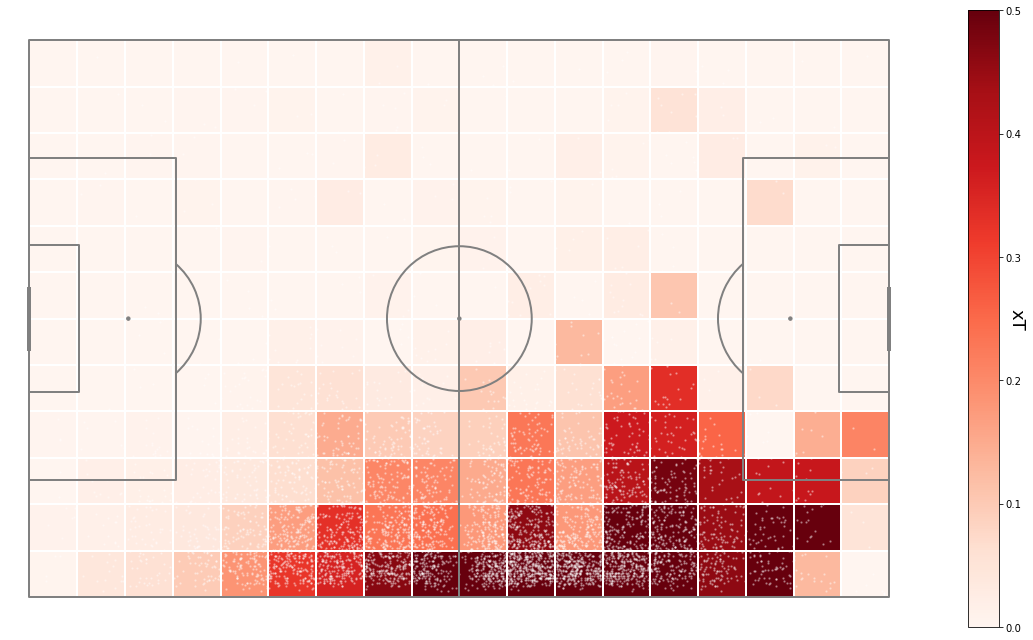

In [496]:
## TAA plot
plot_xTMap(df, 14, ['Pass','Dribble','Cross'], seasons=[1,2,3,4], players=[169187], vmax_override=0.5, saveFlag=1)

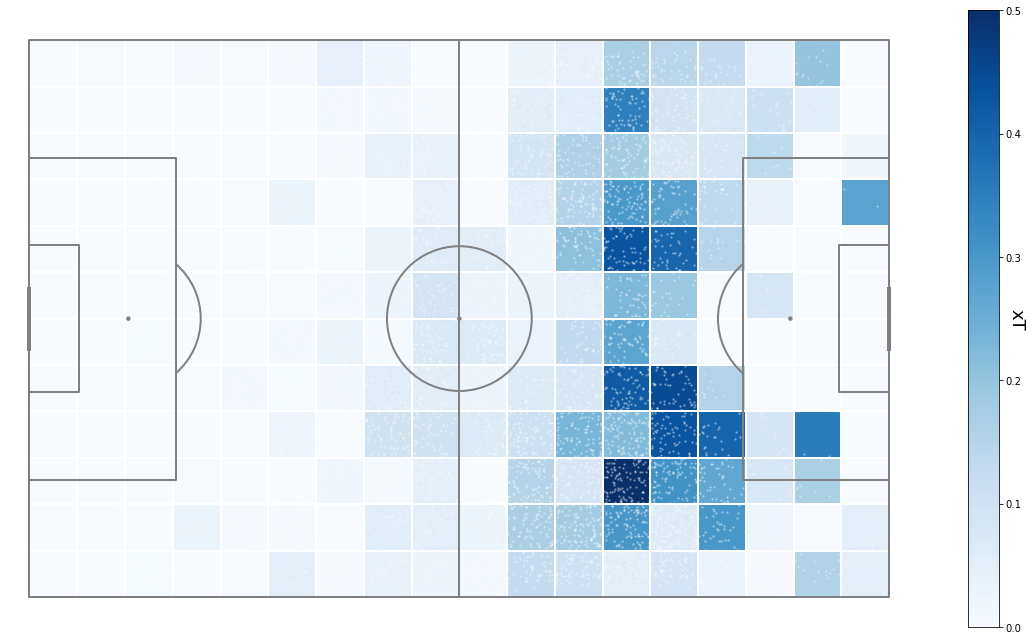

In [497]:
## KDB plot
plot_xTMap(df, 43, ['Pass','Dribble','Cross'], seasons=[1,2,3,4], players=[61366], cmap='Blues', vmax_override=0.5, saveFlag=1)

---

## xG Summary Table for Report

In [498]:
df_xG_summary = df_xT.loc[(df_xT['competition'] == 'English Premier League') & (df_xT['season_excess_xG_per_90_rank'] <= 5), ['season','season_excess_xG_per_90_rank','playerName','excess_xG_per_90','season_xT_per_90_percentile_rank']]\
                .sort_values(['season','season_excess_xG_per_90_rank'])

df_xG_summary['excess_xG_per_90'] = np.round(df_xG_summary.excess_xG_per_90, 3)
df_xG_summary['season_xT_per_90_percentile_rank'] = np.floor(df_xG_summary.season_xT_per_90_percentile_rank).astype(int)

df_xG_summary.to_latex(index=False).replace('\\\\\n','\\')

'\\begin{tabular}{lrlrr}\n\\toprule\n  season &  season\\_excess\\_xG\\_per\\_90\\_rank &                 playerName &  excess\\_xG\\_per\\_90 &  season\\_xT\\_per\\_90\\_percentile\\_rank \\\\midrule\n 2017/18 &                             1 &  Pierre-Emerick Aubameyang &             0.658 &                                34 \\ 2017/18 &                             2 &              Mohamed Salah &             0.541 &                                85 \\ 2017/18 &                             3 &               Oumar Niasse &             0.438 &                                22 \\ 2017/18 &                             4 &              Sergio Agüero &             0.408 &                                43 \\ 2017/18 &                             5 &              Gabriel Jesus &             0.378 &                                 1 \\ 2018/19 &                             1 &              Sergio Agüero &             0.695 &                                 8 \\ 2018/19 &                    

---

## Now Calculating More Granular xT Values

* Pass xT/90
* Cross xT/90
* Dribble xT/90

In [499]:
df_xT_action = df.groupby(['competition','season','playerId','matchId','mainEventType'])\
            .agg({'xT':np.sum,'x1':'count'})\
            .reset_index().rename(columns={'x1':'numActions'})\
            .groupby(['competition','season','playerId','mainEventType'])\
            .agg({'xT':np.sum,'numActions':np.sum})\
            .reset_index()\
            .sort_values('xT', ascending=False)

df_player_mins = df.groupby(['competition','season','playerId','matchId'])\
                .agg({'minsPlayed':np.mean})\
                .reset_index()\
                .groupby(['competition','season','playerId'])\
                .agg({'minsPlayed':np.sum,'matchId':'nunique'})\
                .reset_index()\
                .rename(columns={'matchId':'numMatches'})

# calculating PER 90 metrics
df_xT_action = df_xT_action.merge(df_player_mins)

# applying 900 minute filter
df_xT_action = df_xT_action.loc[(df_xT_action['minsPlayed'] > 900)]

# trimming cols
df_xT_action = df_xT_action[['competition','season','playerId','minsPlayed','mainEventType','xT']]

# only interested in Cross, Dribble, Pass
df_xT_action = df_xT_action.loc[df_xT_action['mainEventType'].isin(['Pass','Dribble','Cross'])]

# pivoting
df_xT_action = df_xT_action.pivot(index=['competition','season','playerId','minsPlayed'], columns=['mainEventType'], values=['xT']).reset_index().fillna(0)

# tidying columns and calculating per 90 metrics
df_xT_action.columns = ['competition','season','playerId','minsPlayed','xT_Cross','xT_Dribble','xT_Pass']
df_xT_action['xT_Cross_per_90'] = (df_xT_action.xT_Cross / df_xT_action.minsPlayed) * 90
df_xT_action['xT_Dribble_per_90'] = (df_xT_action.xT_Dribble / df_xT_action.minsPlayed) * 90
df_xT_action['xT_Pass_per_90'] = (df_xT_action.xT_Pass / df_xT_action.minsPlayed) * 90

# joining on df_players to get player names
df_xT_action = df_xT_action.merge(df_players)

# calculating per 90 RANKs
df_xT_action['season_xT_Cross_per_90_rank'] = df_xT_action.sort_values('xT_Cross_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1
df_xT_action['season_xT_Dribble_per_90_rank'] = df_xT_action.sort_values('xT_Dribble_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1
df_xT_action['season_xT_Pass_per_90_rank'] = df_xT_action.sort_values('xT_Pass_per_90', ascending=False).groupby(['competition','season']).cumcount() + 1

# calculating per 90 rank PERCENTILES
df_xT_action['season_xT_Cross_per_90_pc_rank'] = np.round(100 - df_xT_action.season_xT_Cross_per_90_rank.apply(lambda x: percentileofscore(df_xT_action.season_xT_Cross_per_90_rank.values, x)), 2)
df_xT_action['season_xT_Dribble_per_90_pc_rank'] = np.round(100 - df_xT_action.season_xT_Dribble_per_90_rank.apply(lambda x: percentileofscore(df_xT_action.season_xT_Dribble_per_90_rank.values, x)), 2)
df_xT_action['season_xT_Pass_per_90_pc_rank'] = np.round(100 - df_xT_action.season_xT_Pass_per_90_rank.apply(lambda x: percentileofscore(df_xT_action.season_xT_Pass_per_90_rank.values, x)), 2)

df_xT_action.head()

,competition,season,playerId,minsPlayed,xT_Cross,xT_Dribble,xT_Pass,xT_Cross_per_90,xT_Dribble_per_90,xT_Pass_per_90,playerName,position,season_xT_Cross_per_90_rank,season_xT_Dribble_per_90_rank,season_xT_Pass_per_90_rank,season_xT_Cross_per_90_pc_rank,season_xT_Dribble_per_90_pc_rank,season_xT_Pass_per_90_pc_rank
0,Champions League,2017/18,14937,1221,0.022222,0.093276,-0.114239,0.001638,0.006875,-0.008421,Cristiano Ronaldo,Forward,12,4,26,95.03,98.46,89.01
1,Champions League,2017/18,15157,903,0.137393,0.012575,1.729899,0.013694,0.001253,0.172415,James Milner,Midfielder,7,14,6,97.17,94.17,97.60
2,Champions League,2018/19,15157,928,-0.001474,0.015196,1.787145,-0.000143,0.001474,0.173322,James Milner,Midfielder,37,10,6,84.97,95.88,97.60
3,English Premier League,2017/18,15157,1887,0.474398,0.017582,4.128055,0.022626,0.000839,0.196887,James Milner,Midfielder,57,154,13,79.21,51.43,94.60
4,English Premier League,2018/19,15157,1878,1.127550,0.106032,5.977378,0.054036,0.005081,0.286456,James Milner,Midfielder,8,54,1,96.74,80.06,99.75


In [500]:
df_xT_action.head()

,competition,season,playerId,minsPlayed,xT_Cross,xT_Dribble,xT_Pass,xT_Cross_per_90,xT_Dribble_per_90,xT_Pass_per_90,playerName,position,season_xT_Cross_per_90_rank,season_xT_Dribble_per_90_rank,season_xT_Pass_per_90_rank,season_xT_Cross_per_90_pc_rank,season_xT_Dribble_per_90_pc_rank,season_xT_Pass_per_90_pc_rank
0,Champions League,2017/18,14937,1221,0.022222,0.093276,-0.114239,0.001638,0.006875,-0.008421,Cristiano Ronaldo,Forward,12,4,26,95.03,98.46,89.01
1,Champions League,2017/18,15157,903,0.137393,0.012575,1.729899,0.013694,0.001253,0.172415,James Milner,Midfielder,7,14,6,97.17,94.17,97.60
2,Champions League,2018/19,15157,928,-0.001474,0.015196,1.787145,-0.000143,0.001474,0.173322,James Milner,Midfielder,37,10,6,84.97,95.88,97.60
3,English Premier League,2017/18,15157,1887,0.474398,0.017582,4.128055,0.022626,0.000839,0.196887,James Milner,Midfielder,57,154,13,79.21,51.43,94.60
4,English Premier League,2018/19,15157,1878,1.127550,0.106032,5.977378,0.054036,0.005081,0.286456,James Milner,Midfielder,8,54,1,96.74,80.06,99.75


## **A few queries to look at the top ranked players**

In [501]:
# dribbles
df_xT_action.loc[df_xT_action['season_xT_Dribble_per_90_rank'] <= 5]\
                .sort_values(['competition','season','season_xT_Dribble_per_90_rank'], ascending=[True,True, True])\
                [['competition','season','playerName','xT_Dribble_per_90','season_xT_Dribble_per_90_rank']]

,competition,season,playerName,xT_Dribble_per_90,season_xT_Dribble_per_90_rank
40,Champions League,2017/18,Sadio Mané,0.021263,1
51,Champions League,2017/18,Mohamed Salah,0.020460,2
16,Champions League,2017/18,Marcelo,0.013562,3
0,Champions League,2017/18,Cristiano Ronaldo,0.006875,4
33,Champions League,2017/18,Roberto Firmino,0.005399,5
100,Champions League,2018/19,Raheem Sterling,0.022847,1
82,Champions League,2018/19,Dusan Tadic,0.022039,2
52,Champions League,2018/19,Mohamed Salah,0.021384,3
41,Champions League,2018/19,Sadio Mané,0.019325,4
89,Champions League,2018/19,Son Heung-Min,0.015645,5


In [502]:
# crosses
df_xT_action.loc[df_xT_action['season_xT_Cross_per_90_rank'] <= 5]\
            .sort_values(['competition','season','season_xT_Cross_per_90_rank'], ascending=[True,True, True])\
            [['competition','season','playerName','xT_Cross_per_90','season_xT_Cross_per_90_rank']]

,competition,season,playerName,xT_Cross_per_90,season_xT_Cross_per_90_rank
19,Champions League,2017/18,Aleksandar Kolarov,0.073375,1
20,Champions League,2017/18,Toni Kroos,0.054102,2
57,Champions League,2017/18,Joshua Kimmich,0.041172,3
22,Champions League,2017/18,Alex Sandro,0.027883,4
51,Champions League,2017/18,Mohamed Salah,0.021595,5
123,Champions League,2018/19,Trent Alexander-Arnold,0.078326,1
85,Champions League,2018/19,Christian Eriksen,0.069808,2
122,Champions League,2018/19,Alex Telles,0.052460,3
60,Champions League,2018/19,Lasse Schöne,0.023379,4
73,Champions League,2018/19,Jordi Alba,0.014749,5


In [503]:
# passes
df_xT_action.loc[df_xT_action['season_xT_Pass_per_90_rank'] <= 5]\
            .sort_values(['competition','season','season_xT_Pass_per_90_rank'], ascending=[True,True, True])\
            [['competition','season','playerName','xT_Pass_per_90','season_xT_Pass_per_90_rank']]

,competition,season,playerName,xT_Pass_per_90,season_xT_Pass_per_90_rank
57,Champions League,2017/18,Joshua Kimmich,0.275333,1
51,Champions League,2017/18,Mohamed Salah,0.225071,2
19,Champions League,2017/18,Aleksandar Kolarov,0.180340,3
20,Champions League,2017/18,Toni Kroos,0.178025,4
16,Champions League,2017/18,Marcelo,0.174797,5
122,Champions League,2018/19,Alex Telles,0.303275,1
123,Champions League,2018/19,Trent Alexander-Arnold,0.293881,2
85,Champions League,2018/19,Christian Eriksen,0.207767,3
73,Champions League,2018/19,Jordi Alba,0.203134,4
116,Champions League,2018/19,Hakim Ziyech,0.200041,5


# **Getting Data For Radar Charts**

In [530]:
df_players.loc[df_players['playerName'].str.contains('Aaron')]

,playerId,playerName,position
60,17349,Aaron Lennon,Midfielder
274,41792,Aaron Ramsey,Midfielder
455,55459,Aaron Cresswell,Defender
623,74471,Aaron Mooy,Midfielder
1075,129873,Aaron Samuel,Forward
1149,155513,Rolando Aarons,Midfielder
1502,214590,Aaron Wan-Bissaka,Defender
1583,225321,Aaron Ramsdale,Goalkeeper
1628,232980,Max Aarons,Defender
1629,233425,Aaron Connolly,Forward


## Elo

In [505]:
repo_kpi = r'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/PLAYER KPIs'

In [506]:
# dribble elo
df_elo = pd.read_csv(os.path.join(repo_kpi, 'df_dribble_elo.csv'))

# aerial elo (excluding goalkeepers)
df_aerial_elo = pd.read_csv(os.path.join(repo_kpi, 'df_aerial_elo.csv'))

## **Attack & Defence Elo**

### KANE & CANDIDATES

In [507]:
# KDB and TAA
df_elo.loc[(df_elo['playerId'].isin(['78830','84939','173515','37572'])) & (df_elo['season'] == 'All Seasons')]\
                [['playerName','eloAttack','eloDefence'\
          ,'positionEloDribblePercentileRank','positionEloDribbleDefencePercentileRank']]

,playerName,eloAttack,eloDefence,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
2883,Kelechi Iheanacho,247,-57,97.5,44.1
2960,Sergio Agüero,205,-99,94.2,39.8
3101,Harry Kane,168,-64,86.0,42.9
3240,Danny Ings,149,-52,80.6,44.3


### UNITED 2020/21

In [508]:
# United
df_elo.loc[(df_elo['playerId'].isin(['176297','106760','200617','220688','214590'])) & (df_elo['season'] == '2020/21')]\
                [['playerName','eloAttack','eloDefence'\
          ,'positionEloDribblePercentileRank','positionEloDribbleDefencePercentileRank']]

,playerName,eloAttack,eloDefence,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
2403,Luke Shaw,201,138,91.9,85.9
2408,Mason Greenwood,193,18,89.3,52.4
2442,Aaron Wan-Bissaka,171,158,85.9,95.2
2512,Marcus Rashford,148,-7,75.9,45.5
2783,Daniel James,90,4,46.1,48.0


### Maguire & AWB

In [533]:
# United
df_elo.loc[(df_elo['playerId'].isin(['95658','214590'])) & (df_elo['season'] == 'All Seasons')]\
                [['playerName','eloAttack','eloDefence'\
          ,'positionEloDribblePercentileRank','positionEloDribbleDefencePercentileRank']]

,playerName,eloAttack,eloDefence,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
2831,Harry Maguire,314,167,99.8,94.2
2932,Aaron Wan-Bissaka,215,302,94.7,99.8


### KDB & TRENT

In [425]:
# Kane, 
df_elo.loc[(df_elo['playerId'].isin(['169187','61366'])) & (df_elo['season'] == 'All Seasons')]\
        [['playerName','eloAttack','eloDefence'\
          ,'positionEloDribblePercentileRank','positionEloDribbleDefencePercentileRank']]

,playerName,eloAttack,eloDefence,positionEloDribblePercentileRank,positionEloDribbleDefencePercentileRank
2857,Kevin De Bruyne,269,-56,93.2,2.9
4159,Trent Alexander-Arnold,99,130,18.3,76.9


## **Aerial Elo**

### Aerial: KANE & CANDIDATES

In [509]:
df_aerial_elo.loc[(df_aerial_elo['playerId'].isin(['78830','84939','173515','40720','37572'])) & (df_aerial_elo['season'] == 'All Seasons')]\
        [['playerName','eloAerial','positionEloAerialPercentileRank']]

,playerName,eloAerial,positionEloAerialPercentileRank
3152,Harry Kane,124,88.5
3637,Edinson Cavani,85,70.5
3885,Sergio Agüero,61,58.7
4164,Danny Ings,-23,40.8
4210,Kelechi Iheanacho,-73,38.8


### Aerial: UNITED 2020/21

In [510]:
df_aerial_elo.loc[(df_aerial_elo['playerId'].isin(['176297','106760','200617','220688','214590'])) & (df_aerial_elo['season'] == '2020/21')]\
        [['playerName','eloAerial','positionEloAerialPercentileRank']]

,playerName,eloAerial,positionEloAerialPercentileRank
2356,Marcus Rashford,154,94.3
2360,Luke Shaw,151,56.7
2495,Aaron Wan-Bissaka,93,23.0
2637,Mason Greenwood,42,57.4
2668,Daniel James,23,50.8


### Aerial: Maguire & AWB

In [535]:
df_aerial_elo.loc[(df_aerial_elo['playerId'].isin(['95658','214590'])) & (df_aerial_elo['season'] == 'All Seasons')]\
        [['playerName','eloAerial','positionEloAerialPercentileRank']]

,playerName,eloAerial,positionEloAerialPercentileRank
2726,Harry Maguire,332,99.1
3459,Aaron Wan-Bissaka,96,27.8


### Aerial: KDB & TAA

In [511]:
df_aerial_elo.loc[(df_aerial_elo['playerId'].isin(['169187','61366'])) & (df_aerial_elo['season'] == 'All Seasons')]\
        [['playerName','eloAerial','positionEloAerialPercentileRank']]

,playerName,eloAerial,positionEloAerialPercentileRank
3643,Kevin De Bruyne,85,34.9
4200,Trent Alexander-Arnold,-47,7.8


## **Excess xG**

In [512]:
df_xT_excess_xG_all_seasons = df_xT.loc[df_xT['competition'] == 'English Premier League']\
                        .groupby(['competition','playerId','playerName'])\
                        .agg({'excess_xG':np.sum,'minsPlayed':np.sum})\
                        .reset_index()

# calculating PER 90 metrics
df_xT_excess_xG_all_seasons['excess_xG_per_90'] = (df_xT_excess_xG_all_seasons.excess_xG / df_xT_excess_xG_all_seasons.minsPlayed) * 90

# min mins filter
df_xT_excess_xG_all_seasons = df_xT_excess_xG_all_seasons.loc[(df_xT_excess_xG_all_seasons['minsPlayed'] > 900)]

# calculating per 90 RANKs
df_xT_excess_xG_all_seasons['season_excess_xG_per_90_rank'] = df_xT_excess_xG_all_seasons.sort_values('excess_xG_per_90', ascending=False).groupby(['competition']).cumcount() + 1

# calculating per 90 rank PERCENTILES
df_xT_excess_xG_all_seasons['season_excess_xG_per_90_percentile_rank'] = 100 - df_xT_excess_xG_all_seasons.season_excess_xG_per_90_rank.apply(lambda x: percentileofscore(df_xT_excess_xG_all_seasons.season_excess_xG_per_90_rank.values, x))


### All Seasons Excess xG: Kane & Candidates

In [513]:
df_xT_excess_xG_all_seasons.loc[df_xT_excess_xG_all_seasons['playerId'].isin(['78830','84939','173515','40720','37572'])]\
            [['playerName','excess_xG_per_90','season_excess_xG_per_90_percentile_rank']]

,playerName,excess_xG_per_90,season_excess_xG_per_90_percentile_rank
64,Sergio Agüero,0.638268,99.689441
93,Edinson Cavani,0.610998,99.534161
258,Harry Kane,0.501172,99.068323
287,Danny Ings,0.464902,98.602484
512,Kelechi Iheanacho,0.432800,97.515528


### United 2020/21

In [514]:
df_xT.loc[(df_xT['playerId'].isin(['176297','106760','200617','220688','214590'])) & (df_xT['season'] == '2020/21')]\
            [['playerName','excess_xG_per_90','season_excess_xG_per_90_percentile_rank']]

,playerName,excess_xG_per_90,season_excess_xG_per_90_percentile_rank
39,Luke Shaw,0.032223,34.251969
400,Aaron Wan-Bissaka,0.055883,46.850394
446,Marcus Rashford,0.325016,86.399427
764,Daniel James,0.284510,83.500358
1150,Mason Greenwood,0.331056,87.473157


### All Seasons Excess xG: KDB & TAA

In [515]:
df_xT_excess_xG_all_seasons.loc[df_xT_excess_xG_all_seasons['playerId'].isin([169187,61366])]\
        [['playerName','excess_xG_per_90','season_excess_xG_per_90_percentile_rank']]

,playerName,excess_xG_per_90,season_excess_xG_per_90_percentile_rank
208,Kevin De Bruyne,0.178042,82.298137
492,Trent Alexander-Arnold,0.060912,59.316770


# All Seasons xT Components

In [516]:
df_xT_action_all_seasons = df.groupby(['competition','playerId','matchId','mainEventType'])\
            .agg({'xT':np.sum,'x1':'count'})\
            .reset_index().rename(columns={'x1':'numActions'})\
            .groupby(['competition','playerId','mainEventType'])\
            .agg({'xT':np.sum,'numActions':np.sum})\
            .reset_index()\
            .sort_values('xT', ascending=False)

df_player_mins = df.groupby(['competition','playerId','matchId'])\
                .agg({'minsPlayed':np.mean})\
                .reset_index()\
                .groupby(['competition','playerId'])\
                .agg({'minsPlayed':np.sum,'matchId':'nunique'})\
                .reset_index()\
                .rename(columns={'matchId':'numMatches'})

# calculating PER 90 metrics
df_xT_action_all_seasons = df_xT_action_all_seasons.merge(df_player_mins)

# applying 900 minute filter
df_xT_action_all_seasons = df_xT_action_all_seasons.loc[(df_xT_action_all_seasons['minsPlayed'] > 900)]

# trimming cols
df_xT_action_all_seasons = df_xT_action_all_seasons[['competition','playerId','minsPlayed','mainEventType','xT']]

# only interested in Cross, Dribble, Pass
df_xT_action_all_seasons = df_xT_action_all_seasons.loc[df_xT_action_all_seasons['mainEventType'].isin(['Pass','Dribble','Cross'])]

# pivoting
df_xT_action_all_seasons = df_xT_action_all_seasons.pivot(index=['competition','playerId','minsPlayed'], columns=['mainEventType'], values=['xT']).reset_index().fillna(0)

# tidying columns and calculating per 90 metrics
df_xT_action_all_seasons.columns = ['competition','playerId','minsPlayed','xT_Cross','xT_Dribble','xT_Pass']
df_xT_action_all_seasons['xT_Cross_per_90'] = (df_xT_action_all_seasons.xT_Cross / df_xT_action_all_seasons.minsPlayed) * 90
df_xT_action_all_seasons['xT_Dribble_per_90'] = (df_xT_action_all_seasons.xT_Dribble / df_xT_action_all_seasons.minsPlayed) * 90
df_xT_action_all_seasons['xT_Pass_per_90'] = (df_xT_action_all_seasons.xT_Pass / df_xT_action_all_seasons.minsPlayed) * 90

# joining on df_players to get player names
df_xT_action_all_seasons = df_xT_action_all_seasons.merge(df_players)

# calculating per 90 RANKs
df_xT_action_all_seasons['season_xT_Cross_per_90_rank'] = df_xT_action_all_seasons.sort_values('xT_Cross_per_90', ascending=False).groupby(['competition']).cumcount() + 1
df_xT_action_all_seasons['season_xT_Dribble_per_90_rank'] = df_xT_action_all_seasons.sort_values('xT_Dribble_per_90', ascending=False).groupby(['competition']).cumcount() + 1
df_xT_action_all_seasons['season_xT_Pass_per_90_rank'] = df_xT_action_all_seasons.sort_values('xT_Pass_per_90', ascending=False).groupby(['competition']).cumcount() + 1

# calculating per 90 rank PERCENTILES
df_xT_action_all_seasons['season_xT_Cross_per_90_pc_rank'] = np.round(100 - df_xT_action_all_seasons.season_xT_Cross_per_90_rank.apply(lambda x: percentileofscore(df_xT_action_all_seasons.season_xT_Cross_per_90_rank.values, x)), 2)
df_xT_action_all_seasons['season_xT_Dribble_per_90_pc_rank'] = np.round(100 - df_xT_action_all_seasons.season_xT_Dribble_per_90_rank.apply(lambda x: percentileofscore(df_xT_action_all_seasons.season_xT_Dribble_per_90_rank.values, x)), 2)
df_xT_action_all_seasons['season_xT_Pass_per_90_pc_rank'] = np.round(100 - df_xT_action_all_seasons.season_xT_Pass_per_90_rank.apply(lambda x: percentileofscore(df_xT_action_all_seasons.season_xT_Pass_per_90_rank.values, x)), 2)


### xT: Kane & Candidates

In [522]:
df_xT_action_all_seasons.loc[(df_xT_action_all_seasons['playerId'].isin(['78830','84939','173515','40720','37572'])) & (df_xT_action_all_seasons['competition'] == 'English Premier League')]\
            [['playerName','xT_Cross_per_90','season_xT_Cross_per_90_pc_rank'\
              ,'xT_Dribble_per_90','season_xT_Dribble_per_90_pc_rank'\
              ,'xT_Pass_per_90','season_xT_Pass_per_90_pc_rank']]

,playerName,xT_Cross_per_90,season_xT_Cross_per_90_pc_rank,xT_Dribble_per_90,season_xT_Dribble_per_90_pc_rank,xT_Pass_per_90,season_xT_Pass_per_90_pc_rank
32,Sergio Agüero,0.000676,26.30,0.010493,90.41,0.012234,11.82
47,Edinson Cavani,0.000000,19.78,0.000539,40.41,-0.008793,3.62
125,Harry Kane,0.002592,35.34,0.004106,67.01,0.030228,25.33
486,Danny Ings,0.003144,37.03,0.002015,54.28,0.018244,15.80
691,Kelechi Iheanacho,0.003213,37.52,0.009382,86.79,0.020242,17.85


### 2020/21 United

In [518]:
df_xT_action.loc[(df_xT_action['playerId'].isin(['176297','106760','200617','220688','214590']))\
                 & (df_xT_action['competition'] == 'English Premier League')\
                 & (df_xT_action['season'] == '2020/21')]\
            [['playerName','xT_Cross_per_90','season_xT_Cross_per_90_pc_rank'\
              ,'xT_Dribble_per_90','season_xT_Dribble_per_90_pc_rank'\
              ,'xT_Pass_per_90','season_xT_Pass_per_90_pc_rank']]

,playerName,xT_Cross_per_90,season_xT_Cross_per_90_pc_rank,xT_Dribble_per_90,season_xT_Dribble_per_90_pc_rank,xT_Pass_per_90,season_xT_Pass_per_90_pc_rank
878,Marcus Rashford,0.000218,38.55,0.011091,94.60,0.024373,26.81
1027,Luke Shaw,0.045784,98.03,0.000389,49.71,0.254048,99.32
1128,Aaron Wan-Bissaka,0.007403,63.17,0.000039,35.97,0.071288,69.47
1258,Daniel James,0.000347,39.41,-0.002906,1.32,0.025825,27.95
1281,Mason Greenwood,0.000231,38.83,0.003839,75.77,0.025141,27.38


### xT: KDB & TAA

In [523]:
df_xT_action_all_seasons.loc[(df_xT_action_all_seasons['playerId'].isin([169187,61366])) & (df_xT_action_all_seasons['competition'] == 'English Premier League')]\
            [['playerName','xT_Cross_per_90','season_xT_Cross_per_90_pc_rank'\
              ,'xT_Dribble_per_90','season_xT_Dribble_per_90_pc_rank'\
              ,'xT_Pass_per_90','season_xT_Pass_per_90_pc_rank']]

,playerName,xT_Cross_per_90,season_xT_Cross_per_90_pc_rank,xT_Dribble_per_90,season_xT_Dribble_per_90_pc_rank,xT_Pass_per_90,season_xT_Pass_per_90_pc_rank
101,Kevin De Bruyne,0.03681,91.86,0.010289,89.20,0.271247,99.10
201,Trent Alexander-Arnold,0.04491,95.24,0.000877,44.75,0.267758,98.85
